In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb
from deap import base, creator, tools
from deap.benchmarks import ackley
import catboost as cb
from sklearn.ensemble import VotingClassifier
import random

In [2]:
N_FOLDS = 5
base_path = "/Users/toru/PycharmProjects/isic-2024-challenge"

In [3]:
def lab_to_xyz(L, a, b):
    y = (L + 16) / 116
    x = a / 500 + y
    z = y - b / 200

    xyz = np.array([x, y, z])
    xyz = np.where(xyz > 0.206897, xyz ** 3, (xyz - 16 / 116) / 7.787)
    x, y, z = xyz[0] * 0.95047, xyz[1], xyz[2] * 1.08883
    return x, y, z


def xyz_to_rgb(x, y, z):
    r = x * 3.2406 + y * -1.5372 + z * -0.4986
    g = x * -0.9689 + y * 1.8758 + z * 0.0415
    b = x * 0.0557 + y * -0.2040 + z * 1.0570

    rgb = np.array([r, g, b])
    rgb = np.where(rgb > 0.0031308, 1.055 * (rgb ** (1 / 2.4)) - 0.055, 12.92 * rgb)
    rgb = np.clip(rgb * 255, 0, 255).astype(int)
    return rgb[0], rgb[1], rgb[2]


def lab_to_lch(l, a, b):
    c = np.sqrt(a ** 2 + b ** 2)
    h = np.arctan2(b, a)
    return l, c, h


# lch での色差
def lch_color_difference(l1, c1, h1, l2, c2, h2):
    dl = l1 - l2
    dc = c1 - c2
    dh = h1 - h2
    dh = np.where(dc > 0, dh, dh + 360)
    dh = np.where(dh > 180, dh - 360, dh)
    return np.sqrt(dl ** 2 + dc ** 2 + dh ** 2)

In [20]:
df_train = pd.read_csv(f"{base_path}/train-metadata.csv")
df_test = pd.read_csv(f"{base_path}/test-metadata.csv")


def feature_engineering(df):
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(
        df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(
        df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2)
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df[
        "tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + \
                                 df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt(
        (df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df[
        "tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df[
        "tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] +
                                        df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(
        df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (
            df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (
                                df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (
            2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df[
        "tbp_lv_symm_2axis"]

    # LAB 色空間
    df["A_LAB_inside"] = np.sqrt(df["tbp_lv_A"] ** 2 + df["tbp_lv_B"] ** 2)
    df["H_LAB_inside"] = df["tbp_lv_H"]
    df["L_LAB_inside"] = df["tbp_lv_L"]
    df["A_LAB_outside"] = np.sqrt(df["tbp_lv_Aext"] ** 2 + df["tbp_lv_Bext"] ** 2)
    df["H_LAB_outside"] = df["tbp_lv_Hext"]
    df["L_LAB_outside"] = df["tbp_lv_Lext"]

    # RGB 色空間
    df["R_inside"], df["G_inside"], df["B_inside"] = xyz_to_rgb(
        *lab_to_xyz(df["L_LAB_inside"], df["tbp_lv_A"], df["tbp_lv_B"]))
    df["R_outside"], df["G_outside"], df["B_outside"] = xyz_to_rgb(*lab_to_xyz
    (df["L_LAB_outside"], df["tbp_lv_Aext"], df["tbp_lv_Bext"]))

    # rgb の inside と outside の割合
    df["R_ratio"] = df["R_inside"] / df["R_outside"]
    df["G_ratio"] = df["G_inside"] / df["G_outside"]
    df["B_ratio"] = df["B_inside"] / df["B_outside"]

    # 病変の色の標準偏差と年齢の関係
    df["color_age_interaction"] = df["tbp_lv_color_std_mean"] * df["age_approx"]

    # 病変の面積と年齢の関係
    df['area_age_interaction'] = df['tbp_lv_areaMM2'] * df['age_approx']

    # ネビス信頼度を面積で正規化
    df['nevi_confidence_area'] = df['tbp_lv_nevi_confidence'] / df['tbp_lv_areaMM2']

    # ネビス信頼度を色不規則性で割ったもの
    df['nevi_confidence_color'] = df['tbp_lv_nevi_confidence'] / df['tbp_lv_color_std_mean']

    # 病変の体積
    df['tbp_lv_areaMM3'] = df['3d_position_distance'] * df['tbp_lv_areaMM2']

    # ネビス信頼性と年齢の組み合わせ
    df["nevi_confidence_age_interaction"] = df["tbp_lv_nevi_confidence"] * df["age_approx"]

    # 年齢と発現位置の組み合わせ
    df["combined_anatomical_site_and_age"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]

    # ネビス信頼性と形状の複雑さの組み合わせ
    df["nevi_confidence_shape_interaction"] = df["tbp_lv_nevi_confidence"] * df[
        "shape_complexity_index"]

    # lch での色差
    df["lch_color_difference"] = lch_color_difference(
        df["tbp_lv_L"], df["A_LAB_inside"], df["H_LAB_inside"],
        df["tbp_lv_Lext"], df["A_LAB_outside"], df["H_LAB_outside"]
    )

    # 奥行き (tbp_lv_z) と明るさ (tbp_lv_L) の標準化
    df["tbp_lv_z_stdL"] = df["tbp_lv_z"] * df["tbp_lv_L"]
    
    # tbp_lv_z_stdL と ネビス信頼性の組み合わせ
    df["tbp_lv_z_stdL_nevi_confidence"] = df["tbp_lv_z_stdL"] * df["nevi_confidence_area"]

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast",
        "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",
        "size_age_interaction",
        "hue_color_std_interaction",
        "lesion_severity_index",
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index", "color_age_interaction",
        "area_age_interaction", "color_variance_ratio", "border_color_interaction",
        "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio",
        "age_size_symmetry_index",
    ]
    add_cols = [
        "nevi_confidence_area", "nevi_confidence_color",
        "tbp_lv_areaMM3", "nevi_confidence_age_interaction",
        "nevi_confidence_shape_interaction", "lch_color_difference",
        "tbp_lv_z_stdL", "tbp_lv_z_stdL_nevi_confidence",

        # RGB 色空間
        "A_LAB_inside", "H_LAB_inside", "L_LAB_inside",
        "A_LAB_outside", "H_LAB_outside", "L_LAB_outside",
        "R_inside", "G_inside", "B_inside",
        "R_outside", "G_outside", "B_outside",
        "R_ratio", "G_ratio", "B_ratio",
    ]
    new_num_cols += add_cols
    new_cat_cols = ["combined_anatomical_site", "combined_anatomical_site_and_age"]

    return df, new_num_cols, new_cat_cols, add_cols


df_train, new_num_cols, new_cat_cols, add_cols = feature_engineering(df_train.copy())
df_test, _, _, _ = feature_engineering(df_test.copy())

num_cols = [
               'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B',
               'tbp_lv_Bext',
               'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
               'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
               'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
               'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
               'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
               'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
               'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
               'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
           ] + new_num_cols

cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

# カテゴリ変数をエンコードする
X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

# カテゴリ変数をエンコードする
X_cat = category_encoder.transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

# 特徴量を一部削除する
# 削除する特徴量
remove_cols = [
    "tbp_lv_norm_color",
    "hue_color_std_interaction",
    "L_LAB_inside",
    "tbp_lv_color_std_mean",
    "border_length_ratio",
    "combined_anatomical_site_and_age",
    "sex",
    "log_lesion_area",
    "tbp_lv_location_simple",
    "tbp_tile_type",
    "tbp_lv_stdL",
    "H_LAB_outside",
    "A_LAB_inside",
    "tbp_lv_deltaL",
    "shape_complexity_index",
    "tbp_lv_areaMM3",
    "A_LAB_outside",
    "std_dev_contrast",
    "L_LAB_outside",
]

df_train = df_train.drop(remove_cols, axis=1)
df_test = df_test.drop(remove_cols, axis=1)

# train_cols からも削除する
for col in remove_cols:
    if col in train_cols:
        train_cols.remove(col)

# cat_cols からも削除する
for col in remove_cols:
    if col in cat_cols:
        cat_cols.remove(col)

/var/folders/1j/s9068l9s3pl56py3mj3r1wkh0000gn/T/ipykernel_3720/1475778373.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f"{base_path}/train-metadata.csv")


In [21]:
gkf = GroupKFold(n_splits=N_FOLDS)  # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(
        gkf.split(
            df_train,
            df_train["target"],
            groups=df_train["patient_id"]
        )
):
    df_train.loc[val_idx, "fold"] = idx

In [22]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str,
               min_tpr: float = 0.80):
    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr ** 2 + (max_fpr - 0.5 * max_fpr ** 2) / (1.0 - 0.5) * (
            partial_auc_scaled - 0.5)
    return partial_auc


import random

__n_estimators = random.choice([1400, 1500, 2000])
__learning_rate = random.choice([0.003, 0.002, 0.001])
__lambda_l1 = random.choice([0.14, 0.21, 0.27, 0.37])
__lambda_l2 = random.choice([0.7, 1.0, 1.47, 1.77, 2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04, 0.05, 0.07, 0.077])
__feature_fraction = random.choice([0.5, 0.54, 0.57, 0.7, 0.77, 0.777])
__num_leaves = random.choice([16, 20, 24, 30, 33, 37])
__min_data_in_leaf = random.choice([16, 20, 24, 40, 50, 57])

lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators": __n_estimators,
    'learning_rate': __learning_rate,
    'num_leaves': __num_leaves,
    'min_data_in_leaf': __min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction': __pos_bagging_fraction,
    'neg_bagging_fraction': __neg_bagging_fraction,
    'feature_fraction': __feature_fraction,
    'lambda_l1': __lambda_l1,
    'lambda_l2': __lambda_l2,
    "verbosity": -1,
    'n_jobs': -1,
    # "extra_trees": True
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
      '\n')

scores = []
models = []
for fold in range(N_FOLDS):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    models.append(model)


 1500 0.003 0.27 1.0 0.777 0.07 0.57 33 50 

fold: 0 - Partial AUC Score: 0.16554
fold: 1 - Partial AUC Score: 0.16033
fold: 2 - Partial AUC Score: 0.15210
fold: 3 - Partial AUC Score: 0.16221
fold: 4 - Partial AUC Score: 0.15566


In [23]:
np.mean(scores)

0.1591673699972805

In [24]:
# catboost を使って推論
cb_params = {
    'objective': 'Logloss',
    # "random_state": 42,
    # "colsample_bylevel": 0.3, # 0.01, 0.1
    "iterations": 400,
    "learning_rate": 0.05,
    "cat_features": cat_cols,
    "max_depth": 8,
    "l2_leaf_reg": 5,
    "task_type": "CPU",
    # "scale_pos_weight": 2,
    "verbose": 0,
}
cb_scores = []
cb_models = []
for fold in range(N_FOLDS):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    # model = cb.CatBoostClassifier(**cb_params)
    model = VotingClassifier(
        [(f"cb_{i}", cb.CatBoostClassifier(random_state=i, **cb_params)) for i in range(3)],
        voting="soft")
    # eval_set=(_df_valid[train_cols], _df_valid["target"]), early_stopping_rounds=50
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    cb_scores.append(score)
    cb_models.append(model)

fold: 0 - Partial AUC Score: 0.16580
fold: 1 - Partial AUC Score: 0.16474
fold: 2 - Partial AUC Score: 0.15635
fold: 3 - Partial AUC Score: 0.16219
fold: 4 - Partial AUC Score: 0.15653


In [25]:
# catboost を使って推論した場合のスコア
np.mean(cb_scores)

0.1611201946491176

In [26]:
importances = np.mean([model.feature_importances_ for model in models], 0)
df_imp = pd.DataFrame({"feature": models[0].feature_name_, "importance": importances}).sort_values(
    "importance").reset_index(drop=True)

# 重要度を 0 ~ 1 の範囲に正規化
df_imp["importance"] = df_imp["importance"] / df_imp["importance"].max()

In [27]:
# 重要度順に表示
df_imp

,feature,importance
0,tbp_lv_areaMM2,0.192715
1,lesion_visibility_score,0.224834
2,tbp_lv_perimeterMM,0.246689
3,tbp_lv_nevi_confidence,0.247848
4,shape_color_consistency,0.248841
...,...,...
77,color_contrast_index,0.745199
78,tbp_lv_z,0.792550
79,tbp_lv_deltaB,0.868046
80,tbp_lv_stdLExt,0.901490


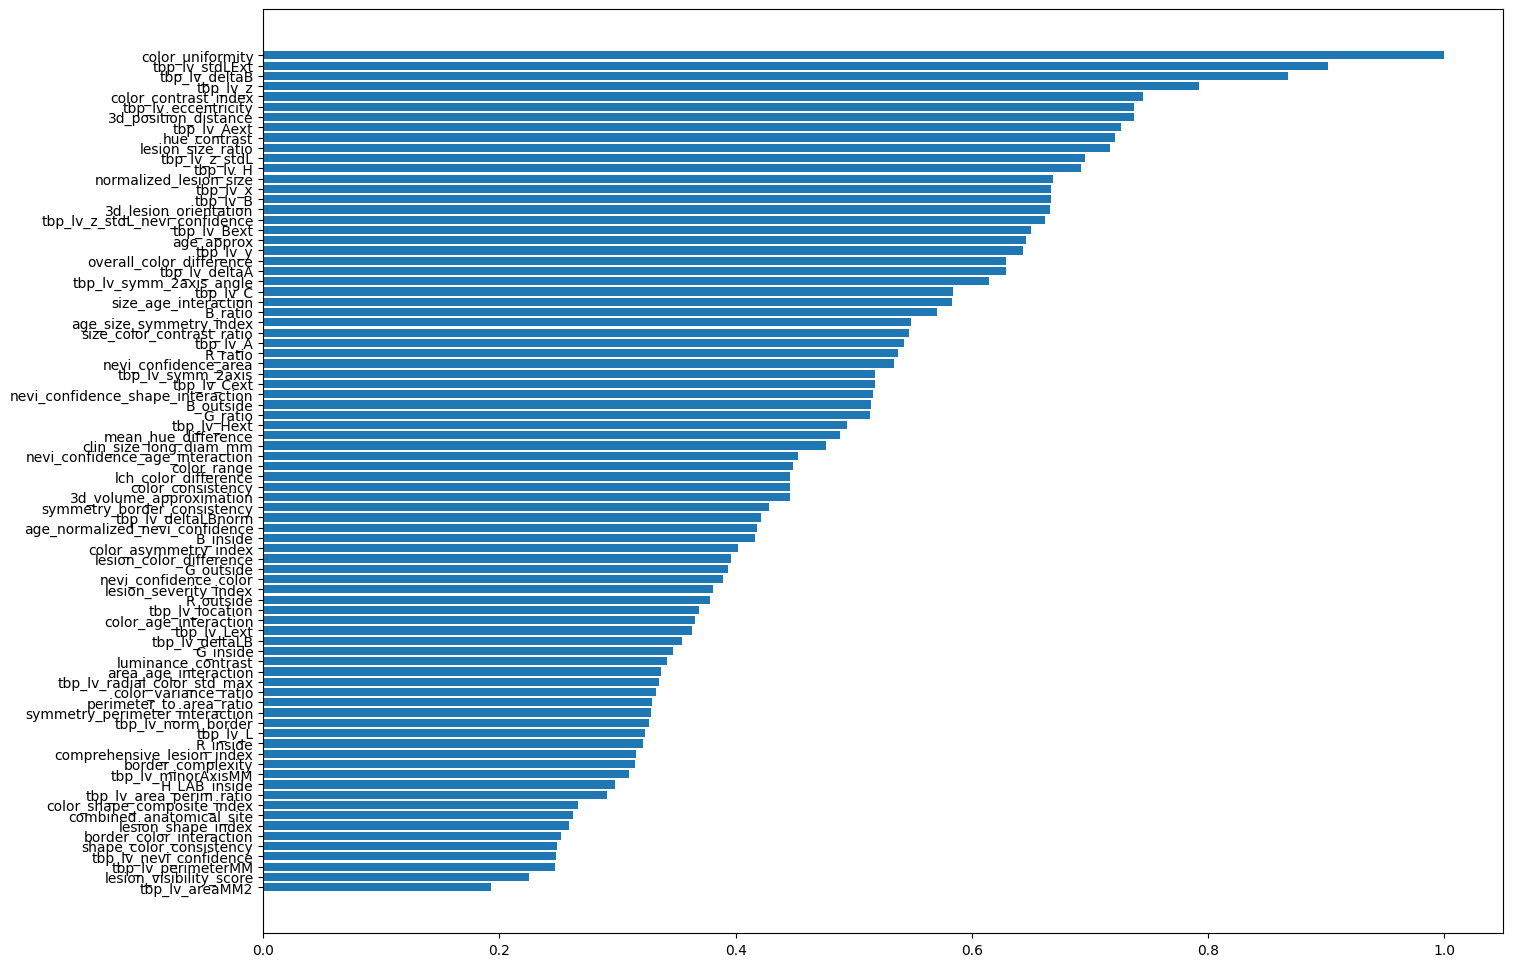

In [28]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [29]:
# How does the new feature(s) perform?
# I would go with the > 20 in the index.
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

In [30]:
def show_feature_importance(feature_name):
    print(f'## {feature_name}')
    print(f'重要度 : {df_imp[df_imp["feature"] == feature_name].importance.values[0]:.5f}')
    print(
        f'順位   : {df_imp[df_imp["feature"] == feature_name].index[0] + 1} / {feature_num}')


# 特徴量の数
feature_num = len(df_imp)
print(f'特徴量の数: {feature_num}')

for col in add_cols:
    # remove_cols に含まれている特徴量は表示しない
    if col in remove_cols:
        continue
    show_feature_importance(col)

特徴量の数: 82
## nevi_confidence_area
重要度 : 0.53427
順位   : 31 / 82
## nevi_confidence_color
重要度 : 0.38974
順位   : 52 / 82
## nevi_confidence_age_interaction
重要度 : 0.45281
順位   : 40 / 82
## nevi_confidence_shape_interaction
重要度 : 0.51639
順位   : 34 / 82
## lch_color_difference
重要度 : 0.44636
順位   : 42 / 82
## tbp_lv_z_stdL
重要度 : 0.69570
順位   : 11 / 82
## tbp_lv_z_stdL_nevi_confidence
重要度 : 0.66175
順位   : 17 / 82
## H_LAB_inside
重要度 : 0.29768
順位   : 72 / 82
## R_inside
重要度 : 0.32185
順位   : 68 / 82
## G_inside
重要度 : 0.34702
順位   : 59 / 82
## B_inside
重要度 : 0.41672
順位   : 48 / 82
## R_outside
重要度 : 0.37864
順位   : 54 / 82
## G_outside
重要度 : 0.39371
順位   : 51 / 82
## B_outside
重要度 : 0.51424
順位   : 35 / 82
## R_ratio
重要度 : 0.53742
順位   : 30 / 82
## G_ratio
重要度 : 0.51374
順位   : 36 / 82
## B_ratio
重要度 : 0.57086
順位   : 26 / 82


In [31]:
preds = np.mean([model.predict(df_test[train_cols]) for model in models], 0)
preds_cb = np.mean([model.predict(df_test[train_cols]) for model in cb_models], 0)

# lightgbm と catboost の結果を平均化
preds = (preds + preds_cb) / 2

In [32]:
# CVスコアの平均
np.mean(np.concatenate([scores, cb_scores]))

0.16014378232319904

In [33]:
df_sub = pd.read_csv(f"{base_path}/sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.000244
1,ISIC_0015729,0.000147
2,ISIC_0015740,0.000515


In [34]:
df_sub.to_csv("submission.csv", index=False)

In [35]:
# 重要度が低い特徴量を10個取得. コピペして使えるようにリスト形式で表示する
for row in df_imp[-10:].itertuples():
    print(f'"{row.feature}",')


"tbp_lv_area_perim_ratio",
"color_shape_composite_index",
"combined_anatomical_site",
"lesion_shape_index",
"border_color_interaction",
"shape_color_consistency",
"tbp_lv_nevi_confidence",
"tbp_lv_perimeterMM",
"lesion_visibility_score",
"tbp_lv_areaMM2",
